In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

512
None
703
None
1089
None
1097
None
315
None
313
None
354
None
698
None
771
None
803
None
477
None
549
None


In [5]:

# def get_nw_loocv(msvd, indices, loocv, hyperparameters):

#     if len(indices) > 1:
#         projections = msvd.reg_proj_vcount_norm_renorm
#         centroids = msvd.centroids
#         nreg = projections.shape[1]
#         nexp = projections.shape[0]
#         nhyp = hyperparameters.shape[0]
#         loocv_predictions = np.zeros((nhyp, nexp, nreg))
#         for g in range(nhyp):
#             loocv_predictions[g, indices] = loocv(projections[indices], centroids[indices], hyperparameters[g])
#         return (loocv_predictions)
#     else:
#         return (np.asarray([]))

In [6]:
def get_homo_loocv(msvd, indices, loocv, hyperparameters):

    if len(indices) > 1:
        projections = msvd.reg_proj_vcount_norm_renorm
        injections = msvd.reg_inj_vcount_norm / np.expand_dims(np.linalg.norm(msvd.reg_inj_vcount_norm, axis = 1),1)
        injections[np.where(np.isnan(injections))] = 0.
        
        nreg = projections.shape[1]
        nexp = projections.shape[0]
        nhyp = hyperparameters.shape[0]
        loocv_predictions = np.zeros((nhyp, nexp, nreg))
        for g in range(nhyp):
            loocv_predictions[g, indices] = loocv(projections[indices], injections[indices], *hyperparameters[g])
        return (loocv_predictions)
    else:
        return (np.asarray([]))

In [12]:
from mcmodels.models.crossvalidation import get_loocv_predictions_nnlinear_number_inj_norm

In [13]:
creline = get_cre_status(data_info, msvds)
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)
leavves = get_leaves_ontologicalorder(msvd, ontological_order)

# contra_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=1)
# ipsi_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=2)

key = list(msvd.experiments.keys())[0]
contra_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

msvds = get_regionalized_normalized_data(msvds,cache, ontological_order,ipsi_key,contra_key,experiments_minor_structures)
thres_ncomp = np.asarray([[1e-10,0]])
wt_2ormore = get_wt_inds(creline)

for sid in major_structure_ids:
    print(sid)
    #print(msvds[sid].projections.shape[0], len(wt_2ormore[sid]))
    msvds[sid].loocv_predictions_all = get_homo_loocv(msvds[sid], np.asarray(list(range(msvds[sid].projections.shape[0]))), get_loocv_predictions_nnlinear_number_inj_norm, thres_ncomp)
    msvds[sid].loocv_predictions_wt = get_homo_loocv(msvds[sid], wt_2ormore[sid], get_loocv_predictions_nnlinear_number_inj_norm, thres_ncomp)


512
exp 0
exp 1
exp 2
exp 3
exp 4
exp 5
exp 6
exp 7
exp 8
exp 9
exp 10
exp 11


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:152: RuntimeWarning: invalid value encountered in true_divide
  predictions[i] = pred / np.linalg.norm(pred)


exp 12
exp 13
exp 14
exp 15
exp 16
exp 17
exp 18
exp 19
exp 20
exp 21
exp 22
exp 23
exp 24
exp 25
exp 26
exp 27
exp 28
exp 29
exp 30
exp 31
exp 32
exp 33
exp 34
exp 35
exp 0
exp 1
exp 2
exp 3
exp 4
exp 5
exp 6
exp 7
exp 8
exp 9
exp 10
exp 11
703
exp 0
exp 1


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:152: RuntimeWarning: invalid value encountered in true_divide
  predictions[i] = pred / np.linalg.norm(pred)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:152: RuntimeWarning: invalid value encountered in true_divide
  predictions[i] = pred / np.linalg.norm(pred)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:152: RuntimeWarning: invalid value encountered in true_divide
  predictions[i] = pred / np.linalg.norm(pred)


exp 2
exp 3
exp 4
exp 5
exp 6
1089
exp 0
exp 1
exp 2
exp 3
exp 4
exp 5
exp 6
exp 7
exp 8
exp 9
exp 10
exp 11
exp 12
exp 13
exp 14
exp 15
exp 16
exp 17
exp 18
exp 19
exp 20
exp 21
exp 22
exp 23
exp 24
exp 25
exp 26
exp 27
exp 28
exp 29
exp 30
exp 31
exp 32
exp 33
exp 34
exp 35
exp 36
exp 37
exp 38
exp 39
exp 40
exp 41
exp 42
exp 43
exp 44
exp 45
exp 46
exp 47
exp 48
exp 49
exp 50
exp 51
exp 52
exp 53
exp 54
exp 55
exp 56
exp 57
exp 58
exp 59
exp 60
exp 61
exp 62
exp 63
exp 64
exp 65
exp 66
exp 67
exp 68
exp 69
exp 70
exp 71
exp 72
exp 73
exp 74
exp 75
exp 76
exp 77
exp 78
exp 79
exp 80
exp 81
exp 82
exp 83
exp 84
exp 85
exp 86
exp 87
exp 88
exp 89
exp 90
exp 91
exp 92
exp 93
exp 94
exp 95
exp 96
exp 97
exp 98
exp 99
exp 100
exp 101
exp 102
exp 103
exp 104
exp 105
exp 106
exp 107
exp 108
exp 109
exp 110
exp 111
exp 112
exp 113
exp 114
exp 115
exp 116
exp 117
exp 118
exp 119
exp 120
exp 121
exp 0
exp 1
exp 2
exp 3
exp 4
exp 5
exp 6
exp 7
exp 8
exp 9
exp 10
exp 11
exp 12
exp 13
exp 14
exp 

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:152: RuntimeWarning: invalid value encountered in true_divide
  predictions[i] = pred / np.linalg.norm(pred)


exp 1
exp 2
exp 3
exp 4
exp 5
exp 6
exp 7
exp 8
exp 9
exp 10
exp 11
exp 12
exp 13
exp 14
exp 15
exp 16
exp 17
exp 18
exp 19
exp 20
exp 21
exp 22
exp 23
exp 24
exp 25
exp 26
exp 27
exp 28
exp 29
exp 30
exp 31
exp 32
exp 33
exp 34
exp 35
exp 36
exp 37
exp 38
exp 39
exp 40
exp 41
exp 42
exp 43
exp 44
exp 45
exp 46
exp 47
exp 48
exp 49
exp 50
exp 51
exp 52
exp 53
exp 54
exp 55
exp 56
exp 57
exp 58
exp 59
exp 60
exp 61
exp 62
exp 63
exp 64
exp 65
exp 66
exp 67
exp 68
exp 69
exp 70
exp 71
exp 72
exp 73
exp 74
exp 75
exp 76
exp 77
exp 78
exp 79
exp 80
exp 81
exp 82
exp 83
exp 84
exp 85
exp 86
exp 87
exp 88
exp 89
exp 90
exp 91
exp 92
exp 93
exp 94
exp 95
exp 96
exp 97
exp 98
exp 99
exp 100
exp 101
exp 102
exp 103
exp 104
exp 105
exp 106
exp 107
exp 108
exp 109
exp 110
exp 111
exp 112
exp 113
exp 114
exp 115
exp 116
exp 117
exp 118
exp 119
exp 120
exp 121
exp 122
exp 123
exp 124
exp 125
exp 126
exp 127
exp 128
exp 129
exp 130
exp 131
exp 132
exp 133
exp 134
exp 135
exp 136
exp 137
exp 138
exp 

exp 1035
exp 1036
exp 1037
exp 1038
exp 1039
exp 1040
exp 1041
exp 1042
exp 1043
exp 1044
exp 1045
exp 1046
exp 1047
exp 1048
exp 1049
exp 1050
exp 1051
exp 1052
exp 1053
exp 1054
exp 1055
exp 1056
exp 1057
exp 1058
exp 1059
exp 1060
exp 1061
exp 1062
exp 1063
exp 1064
exp 1065
exp 1066
exp 1067
exp 1068
exp 1069
exp 1070
exp 1071
exp 1072
exp 1073
exp 1074
exp 1075
exp 1076
exp 1077
exp 1078
exp 1079
exp 1080
exp 1081
exp 1082
exp 1083
exp 1084
exp 1085
exp 1086
exp 1087
exp 1088
exp 1089
exp 1090
exp 1091
exp 1092
exp 1093
exp 1094
exp 1095
exp 1096
exp 1097
exp 1098
exp 1099
exp 1100
exp 1101
exp 1102
exp 1103
exp 1104
exp 1105
exp 1106
exp 1107
exp 1108
exp 1109
exp 1110
exp 1111
exp 1112
exp 1113
exp 1114
exp 1115
exp 1116
exp 1117
exp 1118
exp 1119
exp 1120
exp 1121
exp 1122
exp 1123
exp 1124
exp 1125
exp 1126
exp 1127
exp 0
exp 1
exp 2
exp 3
exp 4
exp 5
exp 6
exp 7
exp 8
exp 9
exp 10
exp 11
exp 12
exp 13
exp 14
exp 15
exp 16
exp 17
exp 18
exp 19
exp 20
exp 21
exp 22
exp 23
exp 2

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:152: RuntimeWarning: invalid value encountered in true_divide
  predictions[i] = pred / np.linalg.norm(pred)


exp 9
exp 10
354
exp 0
exp 1
exp 2
exp 3
exp 4
exp 5
exp 6
exp 7
exp 8
exp 9
exp 10
exp 11
exp 12
exp 13
exp 14
exp 15
exp 16
exp 17
exp 18


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:152: RuntimeWarning: invalid value encountered in true_divide
  predictions[i] = pred / np.linalg.norm(pred)


exp 19
exp 20
exp 21
exp 22
exp 23
exp 24
exp 25
exp 26
exp 27
exp 28
exp 29
exp 30
exp 31
exp 32
exp 33
exp 34
exp 35
exp 36
exp 37
exp 38
exp 39
exp 40
exp 41
exp 42
exp 43
exp 44
exp 45
exp 0
exp 1
exp 2
exp 3
exp 4
exp 5
exp 6
exp 7
exp 8
exp 9
exp 10
exp 11
exp 12
698
exp 0
exp 1
exp 2
exp 3
exp 4


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:152: RuntimeWarning: invalid value encountered in true_divide
  predictions[i] = pred / np.linalg.norm(pred)


exp 5
exp 6
exp 7
exp 8
exp 9
exp 10
exp 11
exp 12
exp 13
exp 14
exp 15
exp 16
exp 17
exp 18
exp 19
exp 20
exp 21
exp 22
exp 23
exp 24
exp 25
exp 26
exp 27
exp 28
exp 29
exp 30
exp 31
exp 32
exp 33
exp 34
exp 0
exp 1
exp 2
exp 3
exp 4
exp 5
exp 6
exp 7
exp 8
771
exp 0
exp 1
exp 2


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:152: RuntimeWarning: invalid value encountered in true_divide
  predictions[i] = pred / np.linalg.norm(pred)


exp 3
exp 4
exp 5
exp 6
exp 7
exp 8
exp 9
exp 10
exp 11
exp 12
exp 13
exp 14
exp 15
exp 16
exp 17
exp 18
exp 19
exp 20
exp 21
exp 22
exp 23
exp 24
exp 25
exp 26
exp 27
exp 28
exp 29
exp 30
exp 31
exp 32
exp 0
exp 1
exp 2
exp 3
803
exp 0
exp 1
exp 2
exp 3
exp 4
exp 5
exp 6
exp 7
exp 8
exp 9
exp 10
exp 11
exp 12
exp 13
exp 14
exp 15
exp 16
exp 17
exp 18
exp 19
exp 20
exp 21
exp 22
exp 23
exp 24
exp 25
exp 26
exp 27
exp 28
exp 29
exp 0
exp 1
exp 2
exp 3
477
exp 0
exp 1
exp 2
exp 3
exp 4
exp 5
exp 6
exp 7
exp 8
exp 9
exp 10
exp 11
exp 12
exp 13
exp 14
exp 15
exp 16
exp 17
exp 18
exp 19
exp 20
exp 21
exp 22
exp 23
exp 24
exp 25
exp 26
exp 27
exp 28
exp 29
exp 30
exp 31
exp 32
exp 33
exp 34
exp 35
exp 36
exp 37
exp 38
exp 39
exp 40
exp 41
exp 42
exp 43
exp 44
exp 45
exp 46
exp 47
exp 48
exp 49
exp 50
exp 51
exp 52
exp 53
exp 54
exp 55
exp 56
exp 57
exp 58
exp 59
exp 60
exp 61
exp 62
exp 63
exp 64
exp 65
exp 66
exp 67
exp 68
exp 69
exp 70
exp 71
exp 72
exp 73
exp 74
exp 75
exp 76
exp 77
exp 0

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:152: RuntimeWarning: invalid value encountered in true_divide
  predictions[i] = pred / np.linalg.norm(pred)


In [22]:
msvds

{512: <mcmodels.core.experiment.VoxelDataset at 0x1251f1690>,
 703: <mcmodels.core.experiment.VoxelDataset at 0x1258cc710>,
 1089: <mcmodels.core.experiment.VoxelDataset at 0x1260027d0>,
 1097: <mcmodels.core.experiment.VoxelDataset at 0x102ab3ed0>,
 315: <mcmodels.core.experiment.VoxelDataset at 0x147e3aad0>,
 313: <mcmodels.core.experiment.VoxelDataset at 0x1044de6d0>,
 354: <mcmodels.core.experiment.VoxelDataset at 0x1256a88d0>,
 698: <mcmodels.core.experiment.VoxelDataset at 0x18e33fbd0>,
 771: <mcmodels.core.experiment.VoxelDataset at 0x1270c4950>,
 803: <mcmodels.core.experiment.VoxelDataset at 0x4879ace10>,
 477: <mcmodels.core.experiment.VoxelDataset at 0x4af962850>,
 549: <mcmodels.core.experiment.VoxelDataset at 0x487d435d0>}

In [7]:
from mcmodels.models.crossvalidation import get_loocv_predictions_nnlinear_number_inj

In [14]:

homo_loocv_predictions_all = {}
homo_loocv_predictions_wt = {}
homo_reg_proj_vcount_norm_renorms= {}
for sid in major_structure_ids:
    homo_loocv_predictions_all[sid ] = msvds[sid].loocv_predictions_all
    homo_loocv_predictions_wt[sid ] = msvds[sid].loocv_predictions_wt
    homo_reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    

In [15]:

inds_good = {}
for sid in major_structure_ids:
    inds_good[sid] = np.asarray(list(range(msvds[sid].injections.shape[0])))
    
a = [list(range(1)), list(range(1))]
keys = np.asarray(list(itertools.product(*a)))
#keys = np.asarray([list(range(keys.shape[0]))])
#sel_ga_wt = get_best_hyperparameters(losses_wts,keys)



In [16]:

def get_loss(true_dict, prediction_dict, pred_ind=None, true_ind=None, keys=None):
    output = {}
    
    major_structure_ids = list(prediction_dict.keys())
    nms = len(major_structure_ids)
    ngam = prediction_dict[major_structure_ids[0]].shape[0]
    nalph = prediction_dict[major_structure_ids[0]].shape[1]
    for m in range(nms):
        sid = major_structure_ids[m]
        if pred_ind == None:
            # prediction_dict and true_dict will contain predictions for 'bad' experiments with no recorded injection
            # when we have the wild type predictions, the subset is what is good among the wild types
            # so 'true' subsetting is always good, since it is w.r.t. the full injection
            # but prediction needs good w.r.t. wt
            pind = np.asarray(list(range(prediction_dict[sid].shape[1])), dtype=int)
        else:
            pind = pred_ind[sid]
        if true_ind == None:
            tind = np.asarray(list(range(true_dict[sid].shape[0])), dtype=int)
        else:
            tind = true_ind[sid]

        nexp = len(pind)

        output[sid] = np.zeros((keys.shape[0], nexp))

        for j in range(keys.shape[0]):
            output[sid][j] = np.asarray(
                [get_loss_paper(true_dict[sid][tind[i]], prediction_dict[sid][j][pind[i]]) for i in
                 range(nexp)])

    return (output)

In [17]:
losses_all = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = inds_good, true_ind = inds_good,keys = keys)
losses_wts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_wt,pred_ind = wt_2ormore, true_ind = wt_2ormore, keys = keys)
losses_allwts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = wt_2ormore, true_ind = wt_2ormore, keys = keys)


In [18]:

sel_ga_all = get_best_hyperparameters(losses_all,keys)
sel_ga_allwt = sel_ga_all#get_gamma(losses_allwt,keys)

mean_nw_all = get_loss_best_hyp(losses_all, sel_ga_all)
mean_nw_allwt = get_loss_best_hyp(losses_allwts, sel_ga_all)
#mean_nw_wt = get_loss_best_hyp(losses_all, sel_ga_wt)

print(mean_nw_all)
print(mean_nw_allwt)

losses = np.asarray([mean_nw_all, 
           mean_nw_allwt]).transpose()
losses2 = losses[[4,7,2,1,10,9,11,3,5,8,6,0]]
loss =pd.DataFrame(losses2, columns = ['all','allwt'])

0
1
2
3
4
5
6
7
8
9
10
11
[0.73357497 0.85418051 0.33094859 0.2797246  0.42350816 0.48577327
 0.42672229 0.41038508 0.556411   0.58513993 0.65333535 0.37239128]
[0.86530157        nan 0.25243498 0.33765169 0.30536101 0.48097761
 0.65418835 0.28883979 0.49643184 0.40926303 0.43059554 0.29425866]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:242: RuntimeWarning: Mean of empty slice
  output[m] = np.nanmean(losses[sid][hyps[m], :])


In [21]:
loss.to_clipboard()

In [19]:
name = 'majorsum_homonormed2x_0720'
expfolder = workingdirectory +   '/data/' + name
os.mkdir(expfolder)
loss.to_csv(expfolder + 'losses')

#msvds_save = {}
for sid in major_structure_ids:
    np.save(expfolder +'/'+ str(sid) + 'reg_proj_vcount_norm_renorm',msvds[sid].reg_proj_vcount_norm_renorm)
    np.save(expfolder +'/'+ str(sid) + 'loocv_predictions_all',msvds[sid].loocv_predictions_all)
    np.save(expfolder +'/'+ str(sid) + 'loocv_predictions_wt',msvds[sid].loocv_predictions_wt)
    
with open(expfolder +'/'+ 'wt_2ormore_base.pickle', 'wb') as handle:
    pickle.dump(wt_2ormore, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#ontological_order_leaf = get_ontological_order_leaf(leafs, ontological_order, st)
#source_exp_countvec, source_exp_countvec_wt = get_countvec(ontological_order, ia_map, creline, experiments_minor_structures)
#hyperparameters = gammas[sel_ga_all]
#leavves v ontological_order_leaf
#leavves is the leaves associated with ontological_order
#ontological_order_leaf is the leaves that are actually present
#leafs is the dictionary with the leaves of the experiments
#df = get_connectivity(msvds, cache, ia_map, hyperparameters, ontological_order_leaf, ontological_order, leafs, creline,experiments_minor_structures, ipsi_key, contra_key)

In [10]:
name = 'majorsum_homo_0720'
expfolder = workingdirectory +   '/data/' + name

homo_loocv_predictions_all = {}
homo_loocv_predictions_wt = {}
homo_reg_proj_vcount_norm_renorms= {}
for sid in major_structure_ids:
    homo_loocv_predictions_all[sid ] = np.load(expfolder +'/'+ str(sid) + 'loocv_predictions_all')
    homo_loocv_predictions_wt[sid ] = np.load(expfolder +'/'+ str(sid) + 'loocv_predictions_wt')
    homo_reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    

FileNotFoundError: [Errno 2] No such file or directory: '/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/data/majorsum_homo_0720/512loocv_predictions_all'

In [ ]:
# def get_homo_loocv(msvd, indices, loocv, hyperparameters):

#     if len(indices) > 1:
#         projections = msvd.reg_proj_vcount_norm_renorm
#         injections = msvd.reg_inj_vcount_norm / np.expand_dims(np.linalg.norm(msvd.reg_inj_vcount_norm, axis = 1),1)
#         injections[np.where(np.isnan(injections))] = 0.
        
#         nreg = projections.shape[1]
#         nexp = projections.shape[0]
#         nhyp = hyperparameters.shape[0]
#         loocv_predictions = np.zeros((nhyp, nexp, nreg))
#         for g in range(nhyp):
#             loocv_predictions[g, indices] = loocv(projections[indices], injections[indices], *hyperparameters[g])
#         return (loocv_predictions)
#     else:
#         return (np.asarray([]))

In [ ]:

# def get_loocv_predictions_nnlinear_number_inj_norm(projections, injections, thresh, number):
#     projections = np.asarray(projections, dtype=np.float32)
#     injections = np.asarray(injections, dtype=np.float32)
#     nexp = projections.shape[0]
#     predictions = np.zeros(projections.shape)
#     homo_est = HomogeneousModel(kappa=np.inf)

#     for i in range(nexp):
#         print('exp', i)
#         otherindices = np.setdiff1d(np.asarray(list(range(nexp))), i)
#         inj, inds = get_reduced_matrix_ninj(injections[otherindices], thresh, number)
#         if inj.shape[1] > 0:
#             homo_est.fit(inj, projections[otherindices])
#             pred = homo_est.predict(injections[i:(i + 1)][:, inds])
#             predictions[i] = pred / np.linalg.norm(pred)

#     return (predictions)


In [31]:
from mcmodels.models.homogeneous import svd_subset_selection, HomogeneousModel
from mcmodels.core.utils import get_reduced_matrix_ninj

In [32]:
    projections = np.asarray(projections, dtype=np.float32)
    injections = np.asarray(injections, dtype=np.float32)
    nexp = projections.shape[0]
    #predictions = np.zeros(projections.shape)
    homo_est = HomogeneousModel(kappa=np.inf)
    inj, inds = get_reduced_matrix_ninj(injections, thresh, number)
    homo_est.fit(inj, projections)

HomogeneousModel(kappa=inf)

In [34]:
homo_est.coef_.shape

(577, 40)

In [46]:
def get_homomodel(projections, injections, thresh, number):
    projections = np.asarray(projections, dtype=np.float32)
    injections = np.asarray(injections, dtype=np.float32)
    nexp = projections.shape[0]
    #predictions = np.zeros(projections.shape)
    homo_est = HomogeneousModel(kappa=np.inf)
    inj, inds = get_reduced_matrix_ninj(injections, thresh, number)
    homo_est.fit(inj, projections)
    return(homo_est.coef_)

In [98]:
source_ordering = ontological_order
hyperparameters = np.asarray(np.tile(np.asarray([[0,0]]).transpose(), 12)).transpose()#np.asarray(np.repeat([[0,0]], 12))
target_ordering = ontological_order

major_structure_ids = np.asarray(list(msvds.keys()))
nms = len(major_structure_ids)
prediction_union_norms = {}
source_region_save = np.asarray([])
coeff_dict = {}
source_target_regions_save = []
for m in range(nms):
    sid = major_structure_ids[m]
    projections = msvds[sid].reg_proj_vcount_norm_renorm
    injections  = msvds[sid].reg_inj_vcount_norm / np.expand_dims(np.linalg.norm(msvds[sid].reg_inj_vcount_norm, axis = 1), axis = 1)
    #thresh = 0
    #number = 0 
    thresh = hyperparameters[m][0]
    number = hyperparameters[m][1]
    coeffs = get_homomodel(projections, injections, thresh, number)
    source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
    source_key = source_mask.get_key(structure_ids=ontological_order)
    source_target_regions, source_target_counts = nonzero_unique(source_key, return_counts=True)
    source_target_regions_save= np.append(source_target_regions_save, source_target_regions)
    #minor_structures = source_ordering[np.where(np.isin(source_ordering, np.unique(leafs[sid])))]
    # ontological_order_leaf np.unique(leafs[sid]) # this should be in ontological order # np.unique(leafs[sid])#source_ordering[sid]#
    coeff_dict[m] = coeffs

    
#source_taget_regions_save[indices] in ontological_order

cd = np.vstack([coeff_dict[m].transpose() for m in range(len(coeff_dict.keys()))])
# get column names
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
target_order = lambda x: np.array(target_ordering)[np.isin(target_ordering, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])
colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

rowreorder = np.squeeze(np.asarray([np.where(source_target_regions_save == ontological_order[i])[0] for i in range(len(ontological_order))]))
# reorder rows and columns
targ_ords = np.concatenate(
    [permutation(ipsi_target_regions), len(ipsi_target_regions) + permutation(contra_target_regions)])
rownames = [ia_map[source_ordering[i]] for i in range(len(source_ordering))]
df = pd.DataFrame(cd[:, targ_ords][rowreorder], index=rownames, columns=np.asarray(colnames))



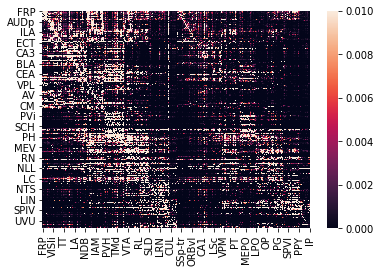

In [102]:
sns.heatmap(df, vmax = .01)

In [105]:
df['VISp']

,VISp,VISp
FRP,0.000000,0.000000
MOp,0.000216,0.000030
MOs,0.001667,0.000508
SSp-n,0.000000,0.000193
SSp-bfd,0.004739,0.000900
...,...,...
PFL,0.003870,0.002155
FL,0.000000,0.000000
FN,0.000044,0.000010
IP,0.000105,0.000052


In [116]:
import os
os.listdir('/Users/samsonkoelle/alleninstitute/mcm_2020/')

['homo1089loocv_predictions_all_ridge.npy',
 'homo315loocv_predictions_wt_npres.npy',
 'voxel315reg_proj_vcount_norm_renorm.npy',
 'homo698loocv_predictions_wt_pca.npy',
 'homo771loocv_predictions_wt_npres.npy',
 'wt_2ormore.pickle',
 'homo703loocv_predictions_all.npy',
 'voxel354loocv_predictions_wt.npy',
 'finest_all_selgammas.npy',
 'finer_voxel_reg_normspredict.pickle',
 'homo698loocv_predictions_all_ic.npy',
 'homo698loocv_predictions_all_npres.npy',
 'mcm_updated_2',
 'leaves_all.csv',
 'voxel703loocv_predictions_all.npy',
 'homo698loocv_predictions_wt.npy',
 'finervoxel1089loocv_predictions_wt.npy',
 'homo512loocv_predictions_all_nmf.npy',
 'finestvoxel1089reg_proj_vcount_norm_renorm.npy',
 'voxel313reg_proj_vcount_norm_renorm.npy',
 'homo1097reg_proj_vcount_norm_renorm.npy',
 'finervoxel549loocv_predictions_all.npy',
 'homo1097loocv_predictions_wt_ridge.npy',
 'homo1089loocv_predictions_wt_ridge.npy',
 'homo315loocv_predictions_wt_ic_conds.npy',
 'summary_structure_wt.csv',
 'c

In [142]:
df

,FRP,MOp,MOs,SSp-n,SSp-bfd,SSp-ll,SSp-m,SSp-ul,SSp-tr,SSp-un,...,NOD,SIM,AN,PRM,COPY,PFL,FL,FN,IP,DN
FRP,0.753710,0.020611,0.092273,0.000000,0.000000,0.000000,0.005412,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000163,0.000072,0.000000,0.000041,0.000046,0.000000,0.000000
MOp,0.009097,0.340614,0.074253,0.021772,0.008249,0.042188,0.036157,0.093210,0.014329,0.066548,...,0.000506,0.000178,0.000456,0.000237,0.000241,0.001146,0.000246,0.000138,0.000132,0.000055
MOs,0.164064,0.120896,0.450437,0.056179,0.025164,0.010318,0.034379,0.031598,0.009188,0.037297,...,0.000823,0.000364,0.000564,0.001256,0.001721,0.002090,0.000774,0.000109,0.000073,0.000030
SSp-n,0.021706,0.036946,0.044024,0.684711,0.028201,0.000000,0.067247,0.030303,0.000000,0.085539,...,0.000857,0.000831,0.000892,0.000512,0.000902,0.001801,0.000510,0.000489,0.000349,0.000215
SSp-bfd,0.000000,0.009924,0.027994,0.016351,0.578193,0.023858,0.000000,0.037688,0.069839,0.169729,...,0.000647,0.000078,0.000256,0.000698,0.001352,0.000681,0.000547,0.000017,0.000031,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PFL,0.000045,0.002116,0.000692,0.008317,0.005443,0.004696,0.004109,0.002345,0.000361,0.000592,...,0.045532,0.049945,0.032516,0.032169,0.044230,0.017736,0.007212,0.002129,0.005323,0.001423
FL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FN,0.000000,0.000033,0.000015,0.000020,0.000019,0.000000,0.000035,0.000005,0.000000,0.000000,...,0.000194,0.001472,0.003041,0.004741,0.005648,0.000063,0.000028,0.080281,0.033975,0.003851
IP,0.000073,0.000111,0.000044,0.000410,0.000222,0.000050,0.000391,0.000072,0.000040,0.000080,...,0.000074,0.000023,0.000041,0.000245,0.001022,0.001220,0.000049,0.000325,0.000113,0.000320


In [157]:
nw = pd.read_csv('/Users/samsonkoelle/alleninstitute/mcm_2020/major_division_all.csv', index_col=0)

In [159]:
nw = nw.iloc[:,:-1]

In [161]:
df

,FRP,MOp,MOs,SSp-n,SSp-bfd,SSp-ll,SSp-m,SSp-ul,SSp-tr,SSp-un,...,NOD,SIM,AN,PRM,COPY,PFL,FL,FN,IP,DN
FRP,0.753710,0.020611,0.092273,0.000000,0.000000,0.000000,0.005412,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000163,0.000072,0.000000,0.000041,0.000046,0.000000,0.000000
MOp,0.009097,0.340614,0.074253,0.021772,0.008249,0.042188,0.036157,0.093210,0.014329,0.066548,...,0.000506,0.000178,0.000456,0.000237,0.000241,0.001146,0.000246,0.000138,0.000132,0.000055
MOs,0.164064,0.120896,0.450437,0.056179,0.025164,0.010318,0.034379,0.031598,0.009188,0.037297,...,0.000823,0.000364,0.000564,0.001256,0.001721,0.002090,0.000774,0.000109,0.000073,0.000030
SSp-n,0.021706,0.036946,0.044024,0.684711,0.028201,0.000000,0.067247,0.030303,0.000000,0.085539,...,0.000857,0.000831,0.000892,0.000512,0.000902,0.001801,0.000510,0.000489,0.000349,0.000215
SSp-bfd,0.000000,0.009924,0.027994,0.016351,0.578193,0.023858,0.000000,0.037688,0.069839,0.169729,...,0.000647,0.000078,0.000256,0.000698,0.001352,0.000681,0.000547,0.000017,0.000031,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PFL,0.000045,0.002116,0.000692,0.008317,0.005443,0.004696,0.004109,0.002345,0.000361,0.000592,...,0.045532,0.049945,0.032516,0.032169,0.044230,0.017736,0.007212,0.002129,0.005323,0.001423
FL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FN,0.000000,0.000033,0.000015,0.000020,0.000019,0.000000,0.000035,0.000005,0.000000,0.000000,...,0.000194,0.001472,0.003041,0.004741,0.005648,0.000063,0.000028,0.080281,0.033975,0.003851
IP,0.000073,0.000111,0.000044,0.000410,0.000222,0.000050,0.000391,0.000072,0.000040,0.000080,...,0.000074,0.000023,0.000041,0.000245,0.001022,0.001220,0.000049,0.000325,0.000113,0.000320


In [162]:
cosine = np.zeros(nw.shape[0])
for i in range(nw.shape[0]):
    cosine[i] = spatial.distance.cosine(nw.iloc[i], df.iloc[i])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


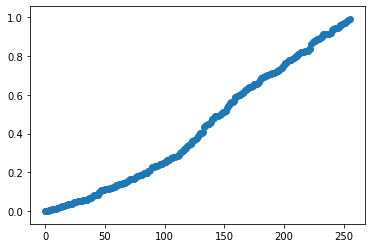

In [163]:
plt.scatter(list(range(len(cosine))),cosine[cosine.argsort()])

In [167]:
nw.index[cosine.argsort()[:20]]

Index(['TR', 'PYR', 'FN', 'SPIV', 'GR', 'CS', 'LD', 'PIR', 'FS', 'IC', 'COAp',
       'PAR', 'PO', 'PRM', 'STN', 'APN', 'MG', 'VCO', 'AN', 'SPVI'],
      dtype='object')

In [119]:
from scipy import spatial

In [76]:
    sid = 512
    source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
    source_key = source_mask.get_key(structure_ids=ontological_order)
    source_target_regions, source_target_counts = nonzero_unique(source_key, return_counts=True)


In [84]:
source_target_regions


array([  91,  846,  912,  920,  928,  936,  944,  951,  957,  968,  989,
       1007, 1017, 1025, 1033, 1041, 1049], dtype=uint32)

In [86]:
np.where(np.isin(ontological_order, source_target_regions))

(array([274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
        287, 288, 289, 290]),)

In [56]:
msvds[sid].injections

(83, 10298)

In [ ]:
#         source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
#         source_key = source_mask.get_key(structure_ids=order)
#         source_target_counts, source_target_counts = nonzero_unique(source_key, return_counts=True)

#         injections = msvd.injections
#         reg_ipsi_inj = unionize(injections, source_key)

In [52]:
df.max()

FRP        7.537100e-01
MOp        3.406142e-01
MOs        4.504370e-01
SSp-n      7.753909e+00
SSp-bfd    5.781935e-01
               ...     
PFL        4.859380e-01
FL         3.225254e+00
FN         7.490166e+05
IP         9.004774e+05
DN         2.243716e+06
Length: 577, dtype: float32

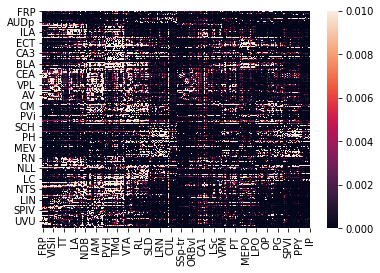

In [54]:
sns.heatmap(df, vmax= .01)

In [70]:
        sid = 549
        source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
        source_key = source_mask.get_key(structure_ids=ontological_order)
        source_target_regions, source_target_counts2 = nonzero_unique(source_key, return_counts=True)

        injections = msvd.injections
        reg_ipsi_inj = unionize(injections, source_key)

In [72]:
source_key.shape

(10298,)

In [62]:
msvd.reg_inj_vcount_norm.shape

(83, 40)

In [60]:
np.asarray(list(source_mask.assigned_structures)).shape

(67,)

In [49]:
[coeff_dict[m] for m in range(len(coeff_dict.keys()))][1].shape

(577, 7)

In [ ]:

def get_connectivity_homo(msvds, cache, ia_map, hyperparameters, source_ordering, target_ordering, leafs, creline,
                     experiments_minor_structures, ipsi_key, contra_key):


    #source_exp_countvec, source_exp_countvec_wt = get_countvec(source_ordering, ia_map, creline,
                                                               experiments_minor_structures)

    major_structure_ids = np.asarray(list(msvds.keys()))
    nms = len(major_structure_ids)
    prediction_union_norms = {}
    source_region_save = np.asarray([])
    coeff_dict = {}
    for m in range(nms):
        sid = major_structure_ids[m]
        projections = msvds[sid].reg_proj_vcount_norm_renorm
        injections  = msvds[sid].reg_inj_vcount_norm / np.expand_dims(np.linalg.norm(msvds[sid].reg_inj_vcount_norm, axis = 1), axis = 1)
        #thresh = 0
        #number = 0 
        thresh = hyperparameters[m][0]
        number = hyperparameters[m][1]
        coeffs = get_homomodel(projections, injections, thresh, number)
        #minor_structures = source_ordering[np.where(np.isin(source_ordering, np.unique(leafs[sid])))]
        # ontological_order_leaf np.unique(leafs[sid]) # this should be in ontological order # np.unique(leafs[sid])#source_ordering[sid]#
        coeff_dict[m] = coeffs
        
    cd = np.vstack([coeff_dict[m] for m in range(len(coeff_dict.keys()))])
    # get column names
    ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
    contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
    target_order = lambda x: np.array(target_ordering)[np.isin(target_ordering, x)]
    permutation = lambda x: np.argsort(np.argsort(target_order(x)))
    targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                               contra_target_regions[permutation(contra_target_regions)]])
    colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

    # reorder rows and columns
    targ_ords = np.concatenate(
        [permutation(ipsi_target_regions), len(ipsi_target_regions) + permutation(contra_target_regions)])
    rownames = [ia_map[source_ordering[i]] for i in range(len(source_ordering))]
    df = pd.DataFrame(cd[:, targ_ords], index=rownames, columns=np.asarray(colnames))
    
    return(cd)
#         for n in range(len(minor_structures)):
#             print(n)
#             minor_structure_inds = np.where(leafs[sid] == minor_structures[n])[0]
#             # meezy = minor_structures[n]
#             im = Mask.from_cache(
#                 cache,
#                 structure_ids=[minor_structures[n]],
#                 hemisphere_id=2)
#             weights = pairwise_kernels(X=msvds[sid].centroids[minor_structure_inds], Y=im.coordinates, metric='rbf',
#                                        gamma=gamma, filter_params=True)
#             weights = weights / weights.sum(axis=0)
#             weights[np.where(np.isnan(weights))] = 0.
#             #weights has dimension number of leaf centroids by number of voxels in leaf
#             predictions = np.dot(weights.transpose(), msvds[sid].reg_proj_vcount_norm_renorm[minor_structure_inds])
#             #predictions has nvoxel in leaf x ntarget
#             #prediction_union_norms is average over source region voxels (nvoxel in leaf)
#             union_key = im.get_key(structure_ids=source_ordering, hemisphere_id=2)
#             source_regions, source_counts = nonzero_unique(union_key, return_counts=True)
#             prediction_union = unionize(predictions.transpose(), union_key)
#             prediction_union_norms[m][n] = prediction_union.transpose() / np.expand_dims(source_counts, 1)
#             source_region_save = np.append(source_region_save, source_regions)

#     prediction_union_norms_ms = {}
#     for m in range(nms):
#         prediction_union_norms_ms[m] = np.vstack(
#             [prediction_union_norms[m][n] for n in range(len(prediction_union_norms[m].keys()))])

#     cd = np.vstack([prediction_union_norms_ms[m] for m in range(len(prediction_union_norms_ms.keys()))])

#     # get row names
#     rownames = [ia_map[source_ordering[i]] for i in range(len(source_ordering))]
#     # rownames = np.asarray(rownames)[np.where(source_exp_countvec !=0)[0]]

#     # get column names
#     ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
#     contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
#     target_order = lambda x: np.array(target_ordering)[np.isin(target_ordering, x)]
#     permutation = lambda x: np.argsort(np.argsort(target_order(x)))
#     targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
#                                contra_target_regions[permutation(contra_target_regions)]])
#     colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

#     # reorder rows and columns
#     targ_ords = np.concatenate(
#         [permutation(ipsi_target_regions), len(ipsi_target_regions) + permutation(contra_target_regions)])
#     row_reorder = np.asarray([])
#     source_region_save = np.asarray(source_region_save, dtype=int)
#     for i in range(len(source_ordering)):
#         inx = np.where(source_region_save == int(source_ordering[i]))[0]
#         if len(inx) > 0:
#             row_reorder = np.append(row_reorder, inx)
#     row_reorder = np.asarray(row_reorder, dtype=int)

#     df = pd.DataFrame(cd[row_reorder][:, targ_ords], index=rownames, columns=np.asarray(colnames))
#     return (df)

In [ ]:

def get_connectivity(msvds, cache, ia_map, hyperparameters, source_ordering, target_ordering, leafs, creline,
                     experiments_minor_structures, ipsi_key, contra_key):

    source_exp_countvec, source_exp_countvec_wt = get_countvec(source_ordering, ia_map, creline,
                                                               experiments_minor_structures)

    major_structure_ids = np.asarray(list(msvds.keys()))
    nms = len(major_structure_ids)
    prediction_union_norms = {}
    source_region_save = np.asarray([])

    for m in range(nms):
        sid = major_structure_ids[m]
        gamma = hyperparameters[m]
        minor_structures = source_ordering[np.where(np.isin(source_ordering, np.unique(leafs[sid])))]
        # ontological_order_leaf np.unique(leafs[sid]) # this should be in ontological order # np.unique(leafs[sid])#source_ordering[sid]#
        prediction_union_norms[m] = {}
        for n in range(len(minor_structures)):
            print(n)
            minor_structure_inds = np.where(leafs[sid] == minor_structures[n])[0]
            # meezy = minor_structures[n]
            im = Mask.from_cache(
                cache,
                structure_ids=[minor_structures[n]],
                hemisphere_id=2)
            weights = pairwise_kernels(X=msvds[sid].centroids[minor_structure_inds], Y=im.coordinates, metric='rbf',
                                       gamma=gamma, filter_params=True)
            weights = weights / weights.sum(axis=0)
            weights[np.where(np.isnan(weights))] = 0.
            #weights has dimension number of leaf centroids by number of voxels in leaf
            predictions = np.dot(weights.transpose(), msvds[sid].reg_proj_vcount_norm_renorm[minor_structure_inds])
            #predictions has nvoxel in leaf x ntarget
            #prediction_union_norms is average over source region voxels (nvoxel in leaf)
            union_key = im.get_key(structure_ids=source_ordering, hemisphere_id=2)
            source_regions, source_counts = nonzero_unique(union_key, return_counts=True)
            prediction_union = unionize(predictions.transpose(), union_key)
            prediction_union_norms[m][n] = prediction_union.transpose() / np.expand_dims(source_counts, 1)
            source_region_save = np.append(source_region_save, source_regions)

    prediction_union_norms_ms = {}
    for m in range(nms):
        prediction_union_norms_ms[m] = np.vstack(
            [prediction_union_norms[m][n] for n in range(len(prediction_union_norms[m].keys()))])

    cd = np.vstack([prediction_union_norms_ms[m] for m in range(len(prediction_union_norms_ms.keys()))])

    # get row names
    rownames = [ia_map[source_ordering[i]] for i in range(len(source_ordering))]
    # rownames = np.asarray(rownames)[np.where(source_exp_countvec !=0)[0]]

    # get column names
    ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
    contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
    target_order = lambda x: np.array(target_ordering)[np.isin(target_ordering, x)]
    permutation = lambda x: np.argsort(np.argsort(target_order(x)))
    targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                               contra_target_regions[permutation(contra_target_regions)]])
    colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

    # reorder rows and columns
    targ_ords = np.concatenate(
        [permutation(ipsi_target_regions), len(ipsi_target_regions) + permutation(contra_target_regions)])
    row_reorder = np.asarray([])
    source_region_save = np.asarray(source_region_save, dtype=int)
    for i in range(len(source_ordering)):
        inx = np.where(source_region_save == int(source_ordering[i]))[0]
        if len(inx) > 0:
            row_reorder = np.append(row_reorder, inx)
    row_reorder = np.asarray(row_reorder, dtype=int)

    df = pd.DataFrame(cd[row_reorder][:, targ_ords], index=rownames, columns=np.asarray(colnames))
    return (df)

In [11]:
# hyperparameters =thres_ncomp
# indices = np.asarray(list(range(msvds[sid].projections.shape[0])))
# msvd = msvds[sid]

In [16]:
#     if len(indices) > 1:
#         projections = msvd.reg_proj_vcount_norm_renorm
#         injections = msvd.reg_inj_vcount_norm / np.expand_dims(np.linalg.norm(msvd.reg_inj_vcount_norm, axis = 1),1)
#         injections[np.where(np.isnan(injections))] = 0.
        
#         nreg = projections.shape[1]
#         nexp = projections.shape[0]
#         nhyp = hyperparameters.shape[0]
#         loocv_predictions = np.zeros((nhyp, nexp, nreg))
#         for g in range(nhyp):
#             loocv_predictions[g, indices] = get_loocv_predictions_nnlinear_number_inj(projections[indices], injections[indices], *hyperparameters[g])
#         #return (loocv_predictions)
#     else:
#         2+2
#         #return (np.asarray([]))

In [15]:
hyperparameters[g]

array([1.e-10, 0.e+00])

In [20]:
get_loocv_predictions_nnlinear_number_inj(projections[indices], injections[indices], *hyperparameters[g])

array([[8.37970339e-03, 2.98649993e-05, 1.32495100e-02, ...,
        7.23178018e-05, 1.21523750e-04, 9.72360067e-05],
       [1.94261614e-02, 1.84335659e-05, 4.46369778e-03, ...,
        0.00000000e+00, 8.17640903e-05, 1.34749070e-03],
       [2.73950435e-02, 1.19056692e-02, 5.60228727e-05, ...,
        5.72578028e-06, 1.03043303e-05, 3.50847782e-04],
       ...,
       [5.06741181e-03, 2.41173602e-05, 1.96433789e-03, ...,
        0.00000000e+00, 0.00000000e+00, 2.05604068e-04],
       [3.45455036e-02, 1.45014897e-02, 4.23544261e-05, ...,
        6.50257243e-06, 1.54651425e-05, 5.33802784e-04],
       [9.55329233e-05, 4.14985407e-05, 1.31462144e-07, ...,
        1.79815256e-08, 4.32830056e-08, 1.48560673e-06]])

In [19]:
*hyperparameters[g]

SyntaxError: can't use starred expression here (<ipython-input-19-870c7af242e9>, line 4)

In [21]:
get_loocv_predictions_nnlinear_number_inj(projections[indices], injections[indices], hyperparameters[g][0], hyperparameters[g][1])

array([[8.37970339e-03, 2.98649993e-05, 1.32495100e-02, ...,
        7.23178018e-05, 1.21523750e-04, 9.72360067e-05],
       [1.94261614e-02, 1.84335659e-05, 4.46369778e-03, ...,
        0.00000000e+00, 8.17640903e-05, 1.34749070e-03],
       [2.73950435e-02, 1.19056692e-02, 5.60228727e-05, ...,
        5.72578028e-06, 1.03043303e-05, 3.50847782e-04],
       ...,
       [5.06741181e-03, 2.41173602e-05, 1.96433789e-03, ...,
        0.00000000e+00, 0.00000000e+00, 2.05604068e-04],
       [3.45455036e-02, 1.45014897e-02, 4.23544261e-05, ...,
        6.50257243e-06, 1.54651425e-05, 5.33802784e-04],
       [9.55329233e-05, 4.14985407e-05, 1.31462144e-07, ...,
        1.79815256e-08, 4.32830056e-08, 1.48560673e-06]])